In [2]:
import pandas as pd
import pickle
import datetime
import numpy as np
from collections import Counter
from itertools import chain 
import re
pd.set_option("display.max_columns",5000)

In [3]:
col=['aid','title','year','nation','language','types','tags','actors','directors']
date = datetime.datetime.today()- datetime.timedelta(1)
yes_date = (datetime.datetime.today() - datetime.timedelta(1)).strftime("%Y%m%d")
media = pd.read_parquet("/data/gangyanyuan/data_rr/doubaninfo_detail_merged_rr_v2")

ldd = media[(media.channel_name=='少儿')&(media.operate_status=='1' )]
print(ldd.shape[0])
ldd = ldd[ldd.vendor_list.apply(lambda x:"310" in x)]
print(ldd.shape[0])
ldd.groupby("content_type").aid.nunique()

20250
12093


content_type
1    12093
Name: aid, dtype: int64

In [4]:
ldd[ldd.title=='小志和玩具第二十季']

,aid,title,channel_name,vendor_list,quality,is_pay,nation,year,types,summarys,directors,score,language,doubanrecommendations,doubanduration,operate_status,content_type,tags,actors,age_min,age_max
125172,MYqzwTgTUJ1670464318083,小志和玩具第二十季,少儿,[310],None,5,[],2020,[动画],[小志和玩具，主要讲述小志哥哥开箱很多玩具，并且解说的视频。],[],8.0,[普通话],[],NaN,1,1,"[益智, 3至6岁]",None,3,6


# result review

In [5]:
import matplotlib.pyplot as plt

In [6]:
date = (datetime.datetime.today() - datetime.timedelta(30)).strftime("%Y%m%d")

In [35]:
def get_data_range(table, diff=18, date_range=18):
    df = []
    for i in range(date_range):
        date = (datetime.datetime.today()-datetime.timedelta(diff) - datetime.timedelta(1+i)).strftime("%Y%m%d")
        try:
            data = pd.read_parquet(f"../airflow_code/ldd_cold_user/{date}_{table}.parquet")
            data['date'] = date
            df.append(data)
        except:
            print('path not exists',f"../liubing/vod analysis/airflow_code/ldd_cold_user/{date}_{table}.parquet")
    df = pd.concat(df)
    return df 

path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230729_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230728_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230723_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230707_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230706_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230705_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230702_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230630_cold_user_metrics_target_date.parquet
path not exists ../liubing/vod analysis/airflow_code/ldd_cold_user/20230629_cold_user_me

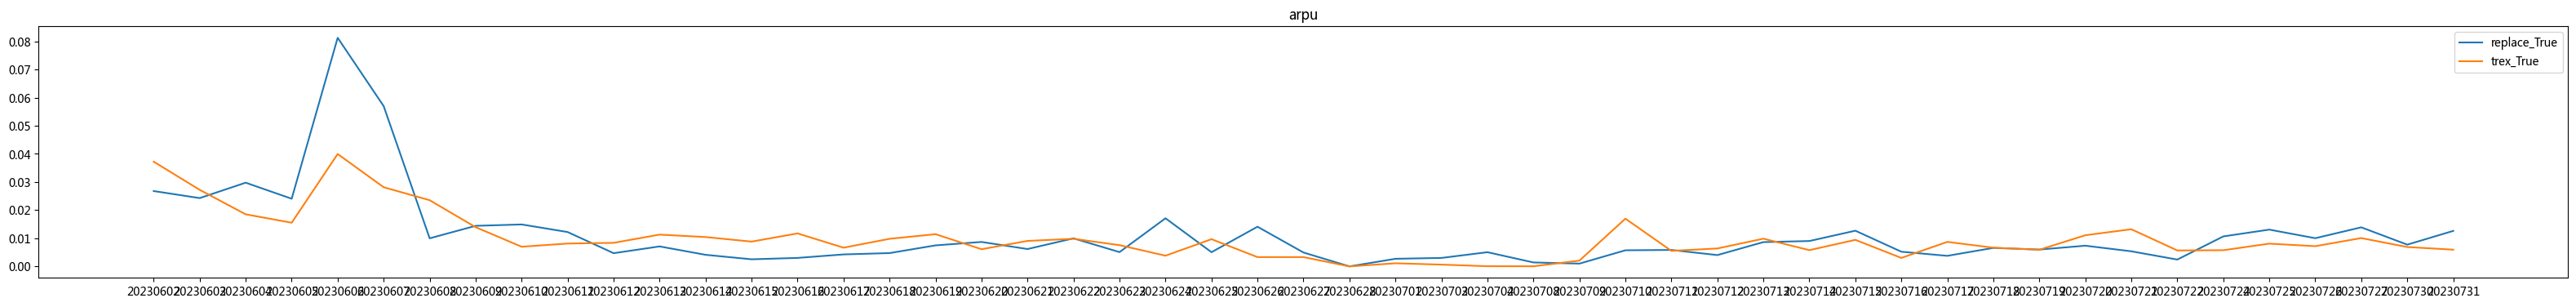

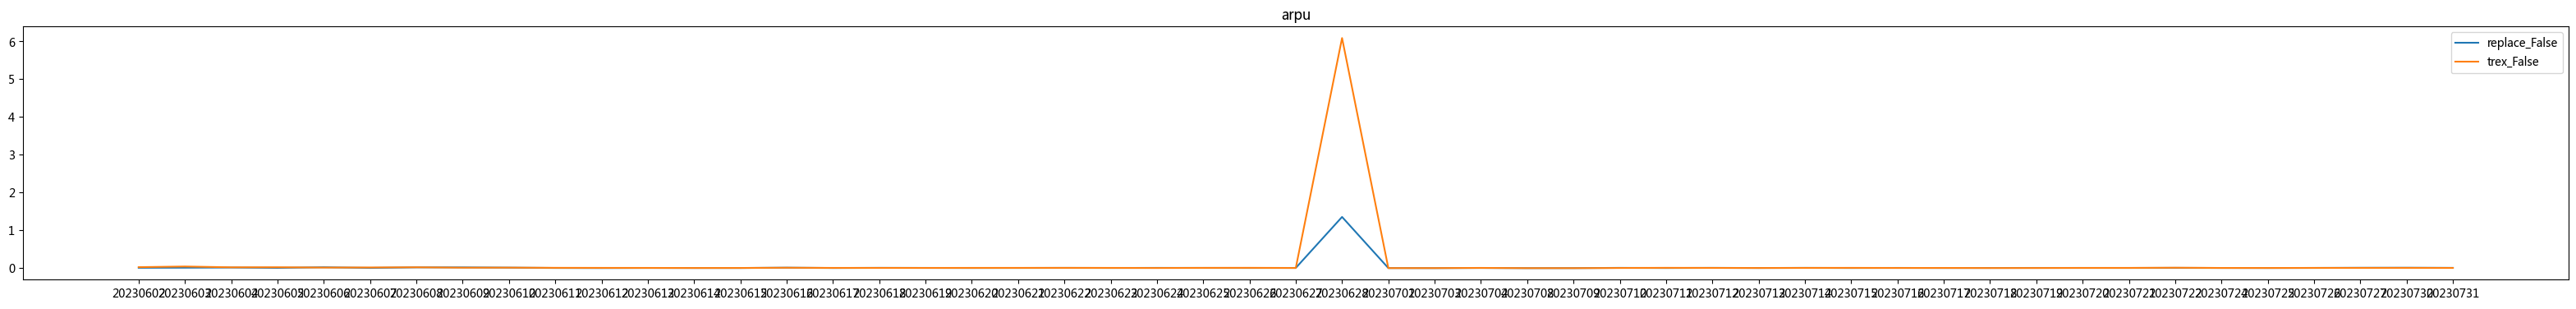

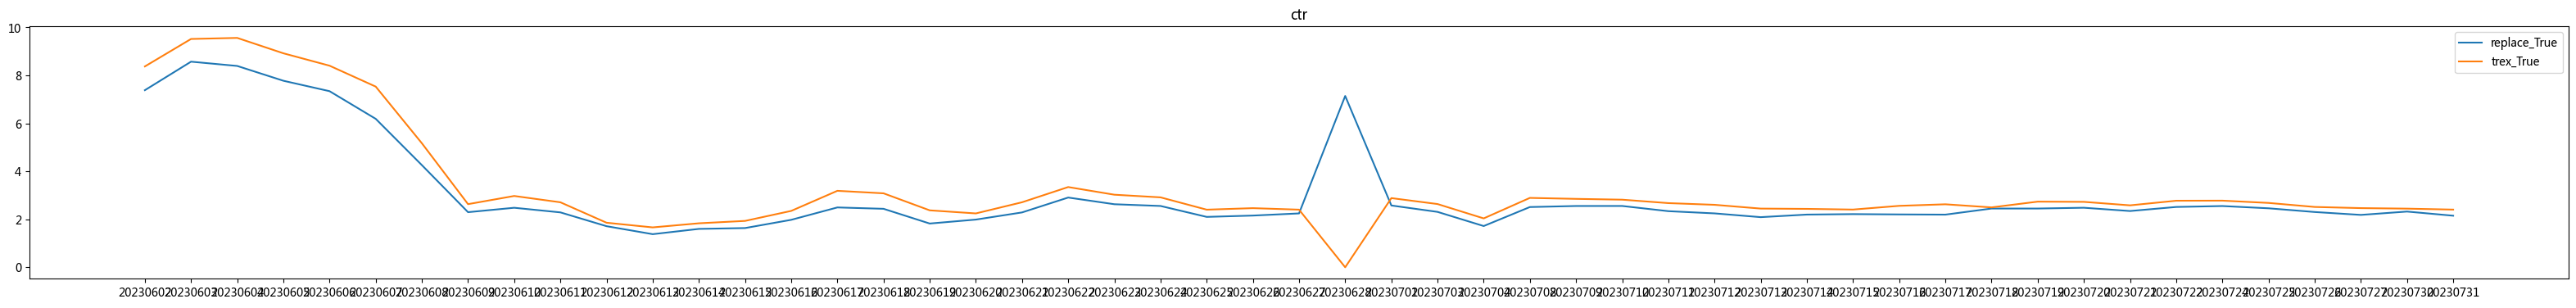

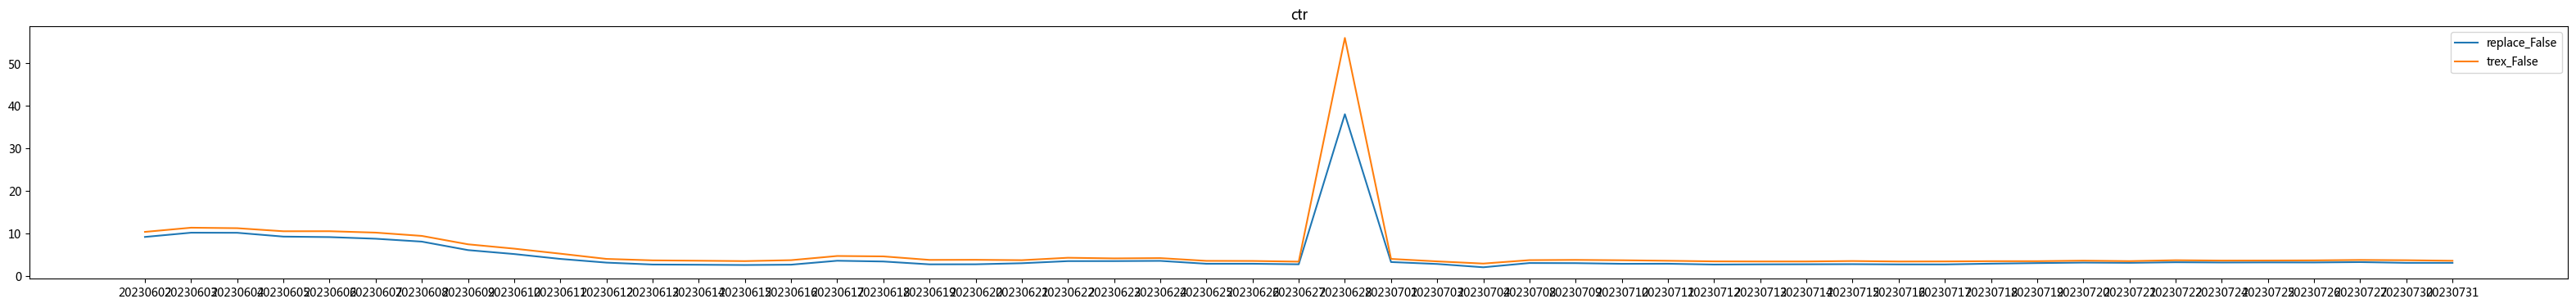

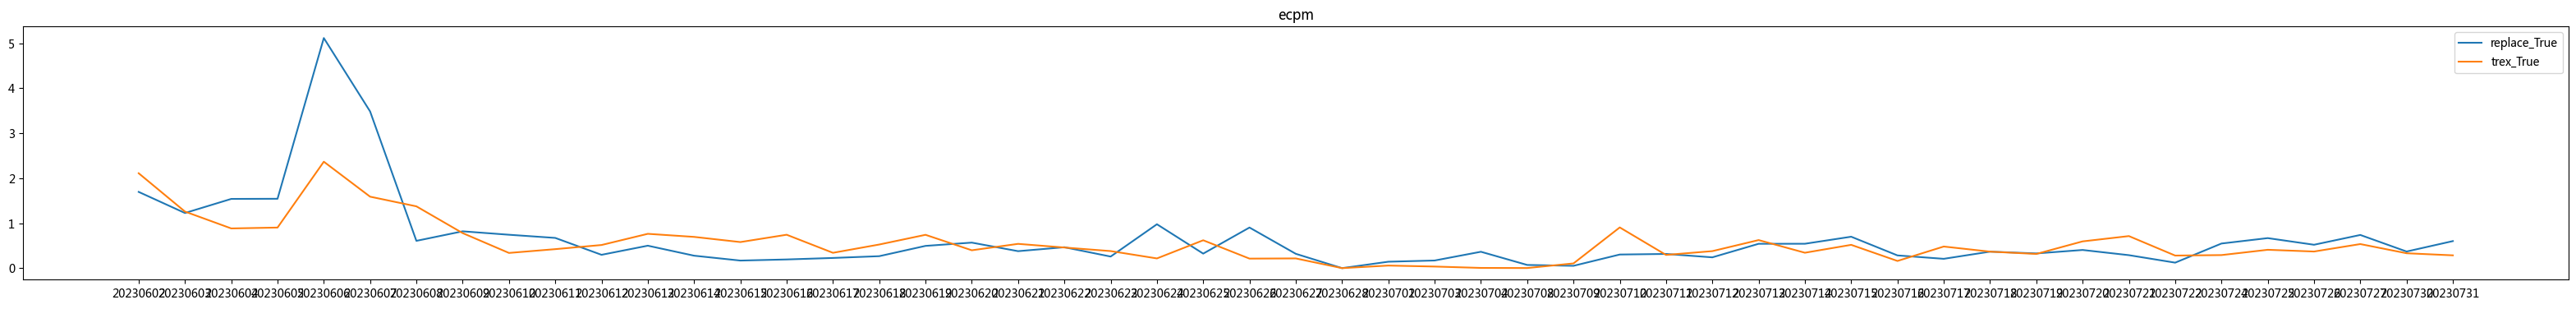

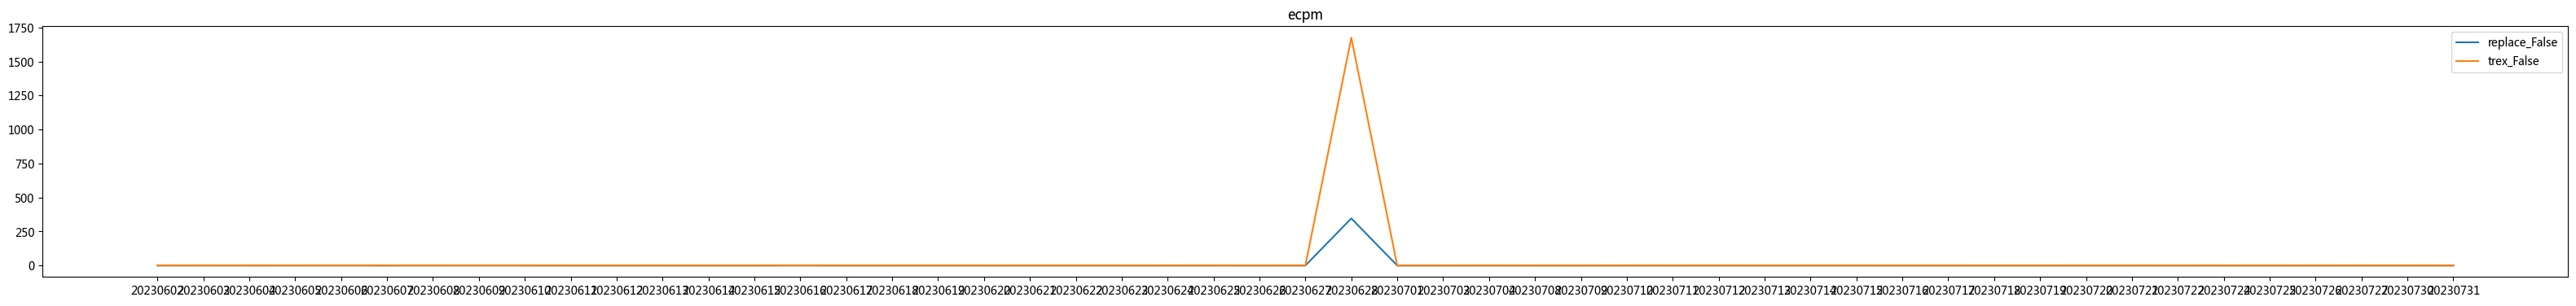

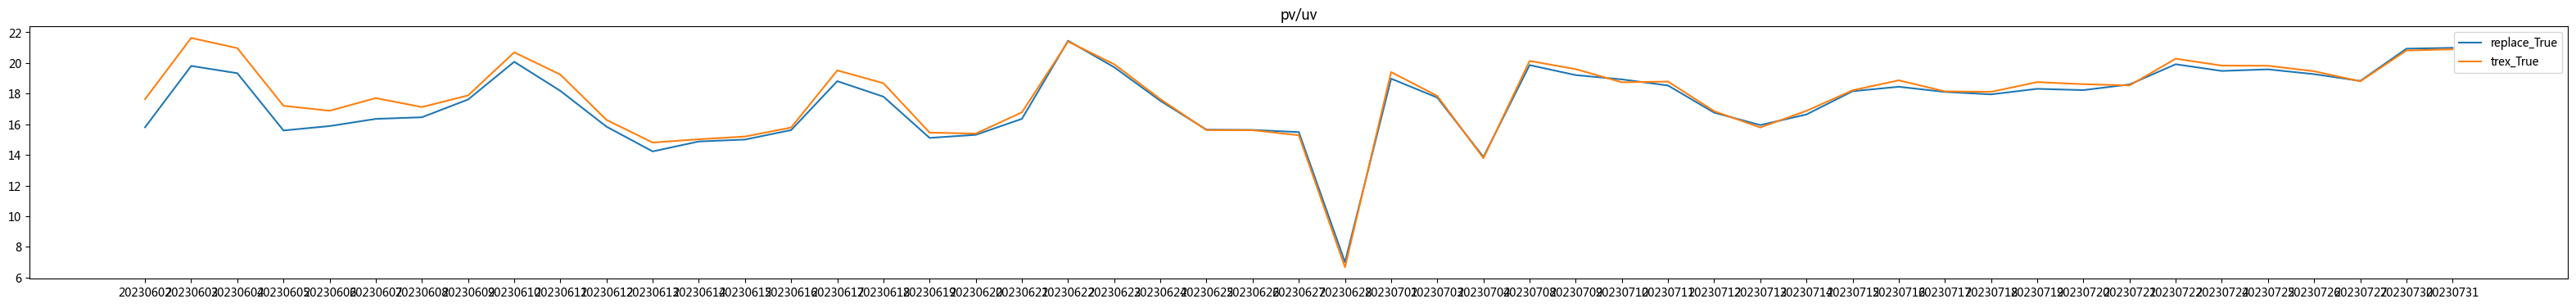

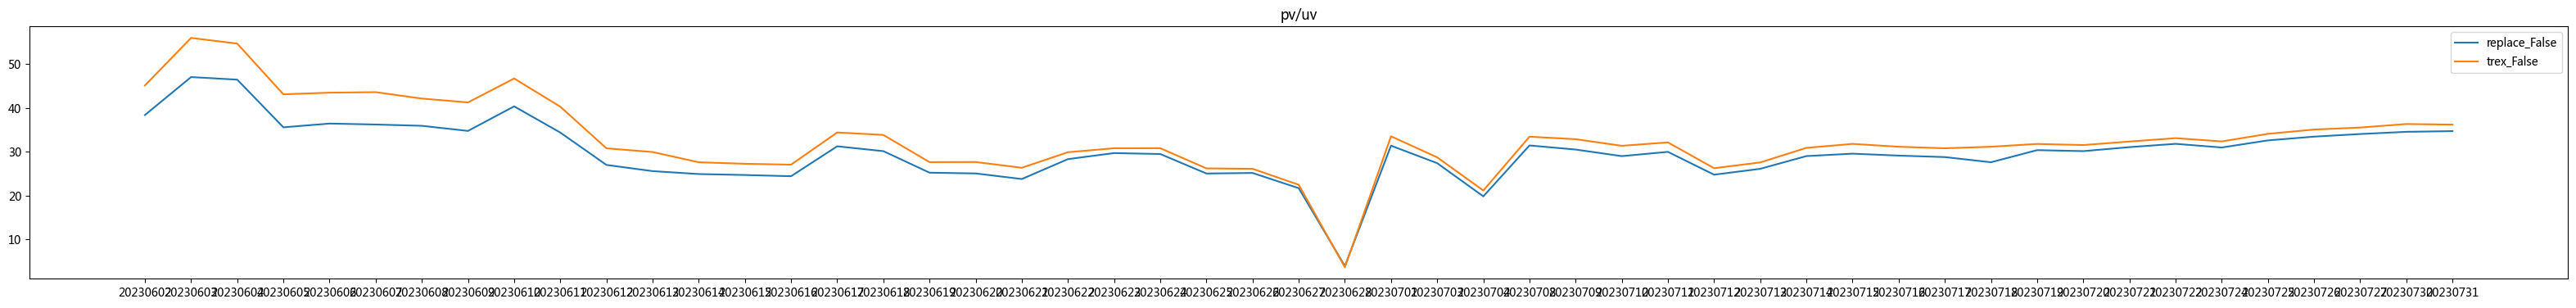

In [36]:
df = get_data_range("cold_user_metrics_target_date", 20,60)
df['pv/uv'] = df.show_pv/df.dnum


for is_cold in [True, False]:
    plt.figure(figsize=(40,4))
    for algo_type in ['replace','trex']:
        tmp = df[(df.algo_type==algo_type)&(df.is_cold==is_cold)].sort_values("date")
        plt.plot(tmp.date, tmp.arpu,label=algo_type+'_'+str(is_cold))
    plt.title("arpu")
    plt.legend()
    plt.show()

for is_cold in [True, False]:
    plt.figure(figsize=(40,4))    
    for algo_type in ['replace','trex']:
        tmp = df[(df.algo_type==algo_type)&(df.is_cold==is_cold)].sort_values("date")
        plt.plot(tmp.date, tmp.ctr,label=algo_type+'_'+str(is_cold))
    plt.title("ctr")
    plt.legend()
    plt.show()

for is_cold in [True, False]:
    plt.figure(figsize=(40,4))    
    for algo_type in ['replace','trex']:
        tmp = df[(df.algo_type==algo_type)&(df.is_cold==is_cold)].sort_values("date")
        plt.plot(tmp.date, tmp.ecpm,label=algo_type+'_'+str(is_cold))
    plt.title("ecpm")
    plt.legend()
    plt.show()

for is_cold in [True, False]:
    plt.figure(figsize=(40,4))    
    for algo_type in ['replace','trex']:
        tmp = df[(df.algo_type==algo_type)&(df.is_cold==is_cold)].sort_values("date")
        plt.plot(tmp.date, tmp['pv/uv'],label=algo_type+'_'+str(is_cold))
    plt.title("pv/uv")
    plt.legend()
    plt.show()

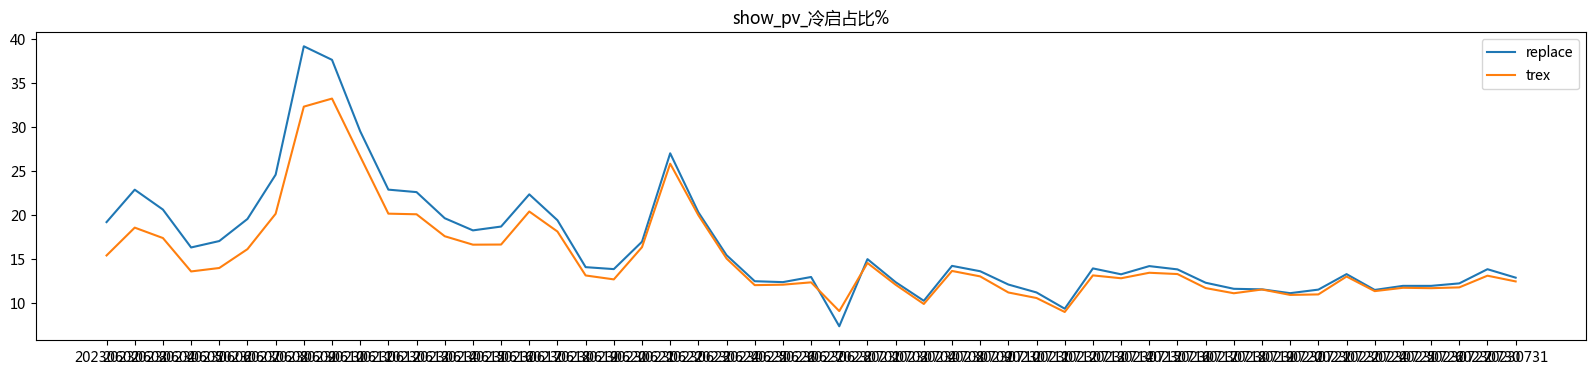

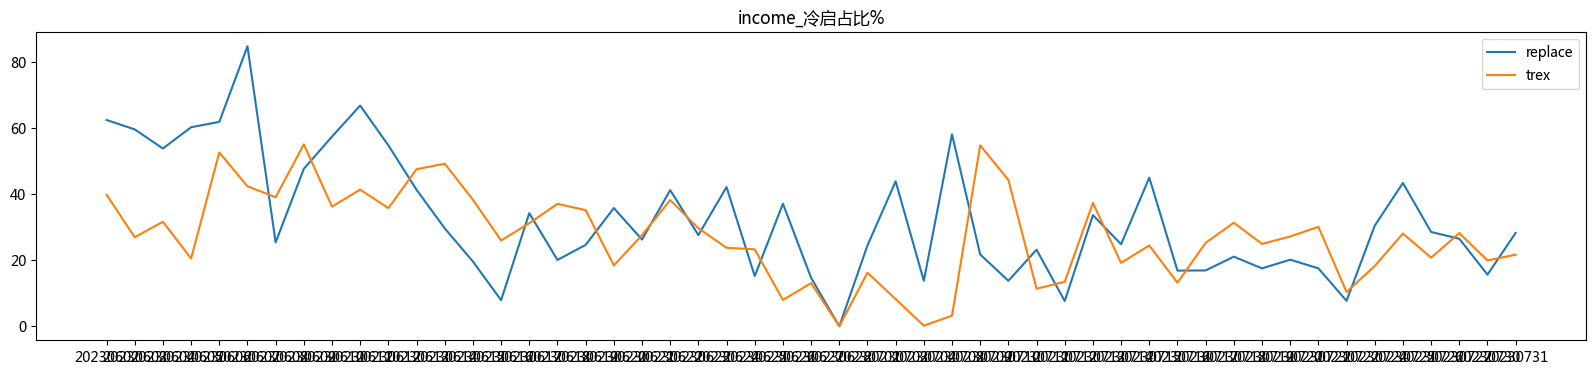

In [31]:
df_date_pv = pd.pivot_table(df,columns=['is_cold'],index=['algo_type','date'],values=['show_pv',"income_filter"]).reset_index()
df_date_pv.columns=['algo_type','date','income_filter_活跃','income_filter_冷启','show_pv_活跃','show_pv_冷启',]
df_date_pv['show_pv_冷启占比'] = df_date_pv.show_pv_冷启/(df_date_pv.show_pv_活跃+df_date_pv.show_pv_冷启)*100
df_date_pv['income_冷启占比'] = df_date_pv.income_filter_冷启/(df_date_pv.income_filter_活跃+df_date_pv.income_filter_冷启)*100
plt.figure(figsize=(20,4))   
for algo_type in ['replace','trex']:
    
    tmp = df_date_pv[(df_date_pv.algo_type==algo_type)].sort_values("date")
    plt.plot(tmp.date, tmp.show_pv_冷启占比,label=algo_type)
plt.title("show_pv_冷启占比%")
plt.legend()
plt.show()
plt.figure(figsize=(20,4))   
for algo_type in ['replace','trex']:
    
    tmp = df_date_pv[(df_date_pv.algo_type==algo_type)].sort_values("date")
    plt.plot(tmp.date, tmp.income_冷启占比,label=algo_type)
plt.title("income_冷启占比%")
plt.legend()
plt.show()

In [32]:
ecpm_sup = (df_date_pv[df_date_pv.algo_type=='replace'].income_filter_冷启.sum()/2*7+df_date_pv[df_date_pv.algo_type=='trex'].income_filter_活跃.sum())/(df_date_pv[df_date_pv.algo_type=='trex'].show_pv_活跃.sum()+df_date_pv[df_date_pv.algo_type=='trex'].show_pv_冷启.sum())*1000

In [33]:
ecpm_sup

0.3233032950126679

In [10]:
ecpm_trex = (df_date_pv[df_date_pv.algo_type=='trex'].income_filter_冷启.sum()+df_date_pv[df_date_pv.algo_type=='trex'].income_filter_活跃.sum())/(df_date_pv[df_date_pv.algo_type=='trex'].show_pv_活跃.sum()+df_date_pv[df_date_pv.algo_type=='trex'].show_pv_冷启.sum())*1000
ecpm_replace = (df_date_pv[df_date_pv.algo_type=='replace'].income_filter_冷启.sum()+df_date_pv[df_date_pv.algo_type=='replace'].income_filter_活跃.sum())/(df_date_pv[df_date_pv.algo_type=='replace'].show_pv_活跃.sum()+df_date_pv[df_date_pv.algo_type=='replace'].show_pv_冷启.sum())*1000

In [44]:
ecpm_trex,ecpm_replace

(0.9449930077239146, 1.2912111351483462)

In [45]:
(ecpm_trex - ecpm_replace)/ecpm_replace*100,\
(ecpm_sup - ecpm_replace)/ecpm_replace*100

(-26.813440342942435, -17.070125620979855)

In [46]:
(ecpm_trex - ecpm_replace)/ecpm_replace*100,\
(ecpm_sup - ecpm_replace)/ecpm_replace*100

(-26.813440342942435, -17.070125620979855)

In [11]:
df = get_data_range("cold_user_per_15_days", 14)

df['algo_type'] = df.bucket.apply(lambda x: 'replace' if x  in ['8','9'] else 'trex')
display(df[df.bucket.isin(['7','6'])].head(20))
display(df[(df.date>='20230509')&(df.bucket.isin(['6','7','0']))])
df_group  = df.groupby(["date","algo_type"]).agg({"当天冷启动用户数量_曝光":"mean", "当天有付费行为的曝光冷启动用户数量":"mean"}).reset_index()
df_group['当天曝光冷启动用户中,付费用户占比%']  = df_group.当天有付费行为的曝光冷启动用户数量/ df_group.当天冷启动用户数量_曝光*100

df_group

,bucket,历史N天用户数量_付费,当天用户数量_付费,当天冷启动用户数量_付费,当天冷启动用户占比_付费,历史N天用户数量_曝光,当天用户数量_曝光,当天冷启动用户数量_曝光,当天冷启动用户占比_曝光,当天有付费行为的曝光冷启动用户数量,"当天曝光冷启动用户中,付费用户占比%","当天付费用户中,曝光冷启动用户占比%",date,algo_type
5,6,146,14,14,100.000000,156229,51060,14805,28.995300,4,0.027018,28.571429,20230618,trex
6,7,160,19,19,100.000000,155123,51026,14705,28.818641,13,0.088405,68.421053,20230618,trex
5,6,138,18,18,100.000000,143813,50207,15903,31.674866,5,0.031441,27.777778,20230617,trex
6,7,153,15,15,100.000000,142943,49854,15586,31.263289,8,0.051328,53.333333,20230617,trex
5,6,142,10,10,100.000000,135810,39412,10233,25.964173,5,0.048862,50.000000,20230616,trex
6,7,149,10,10,100.000000,135486,38790,9685,24.967775,5,0.051626,50.000000,20230616,trex
5,6,146,12,12,100.000000,128444,37867,10110,26.698709,4,0.039565,33.333333,20230615,trex
6,7,149,14,14,100.000000,128447,37596,9715,25.840515,4,0.041173,28.571429,20230615,trex
5,6,143,12,12,100.000000,119573,36891,10644,28.852566,6,0.056370,50.000000,20230614,trex
6,7,150,9,9,100.000000,119880,36393,10284,28.258182,2,0.019448,22.222222,20230614,trex


,bucket,历史N天用户数量_付费,当天用户数量_付费,当天冷启动用户数量_付费,当天冷启动用户占比_付费,历史N天用户数量_曝光,当天用户数量_曝光,当天冷启动用户数量_曝光,当天冷启动用户占比_曝光,当天有付费行为的曝光冷启动用户数量,"当天曝光冷启动用户中,付费用户占比%","当天付费用户中,曝光冷启动用户占比%",date,algo_type
0,0,156,17,17,100.000000,161253,51936,14626,28.161583,4,0.027349,23.529412,20230618,trex
5,6,146,14,14,100.000000,156229,51060,14805,28.995300,4,0.027018,28.571429,20230618,trex
6,7,160,19,19,100.000000,155123,51026,14705,28.818641,13,0.088405,68.421053,20230618,trex
0,0,164,14,14,100.000000,148728,51204,15737,30.733927,7,0.044481,50.000000,20230617,trex
5,6,138,18,18,100.000000,143813,50207,15903,31.674866,5,0.031441,27.777778,20230617,trex
6,7,153,15,15,100.000000,142943,49854,15586,31.263289,8,0.051328,53.333333,20230617,trex
0,0,154,17,17,100.000000,140051,41918,10605,25.299394,8,0.075436,47.058824,20230616,trex
5,6,142,10,10,100.000000,135810,39412,10233,25.964173,5,0.048862,50.000000,20230616,trex
6,7,149,10,10,100.000000,135486,38790,9685,24.967775,5,0.051626,50.000000,20230616,trex
0,0,154,13,13,100.000000,132313,39414,10229,25.952707,6,0.058657,46.153846,20230615,trex


,date,algo_type,当天冷启动用户数量_曝光,当天有付费行为的曝光冷启动用户数量,"当天曝光冷启动用户中,付费用户占比%"
0,20230605,replace,2170.000000,5.000000,0.230415
1,20230605,trex,2246.571429,3.142857,0.139896
2,20230606,replace,2322.500000,4.500000,0.193757
3,20230606,trex,2411.428571,6.285714,0.260664
4,20230607,replace,2817.000000,7.000000,0.248491
5,20230607,trex,2918.428571,7.000000,0.239855
6,20230608,replace,4288.500000,5.500000,0.128250
7,20230608,trex,4309.857143,6.285714,0.145845
8,20230609,replace,11574.500000,11.000000,0.095037
9,20230609,trex,11205.142857,5.142857,0.045897


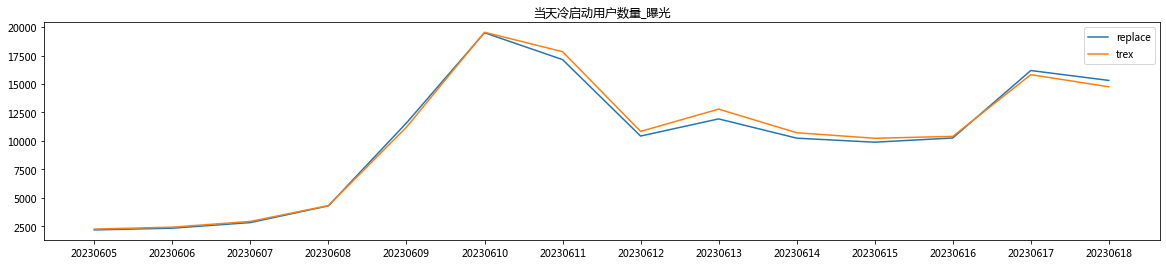

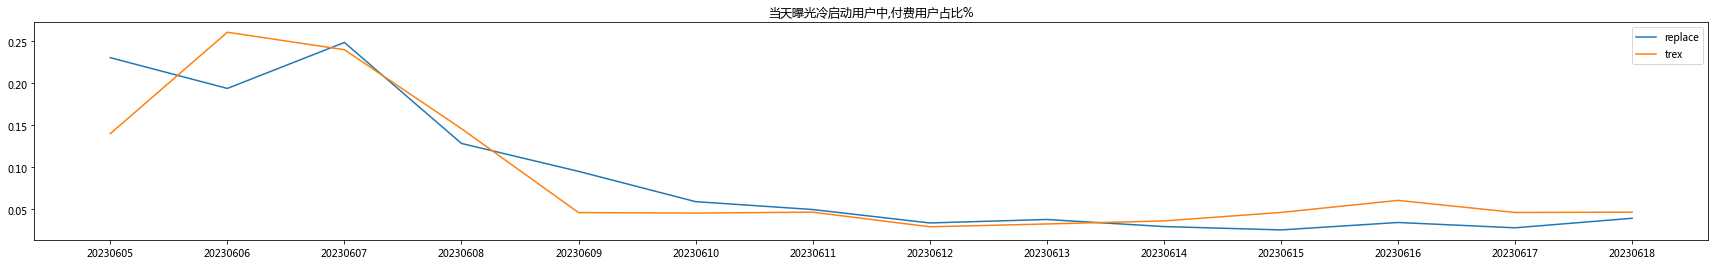

In [12]:
plt.figure(figsize=(20,4))   
for group in ['replace','trex']:
    tmp = df_group[(df_group.algo_type==group)].sort_values("date")
    plt.plot(tmp.date, tmp['当天冷启动用户数量_曝光'],label=group)
plt.title("当天冷启动用户数量_曝光")
plt.legend()
plt.show()

plt.figure(figsize=(30,4))   
for group in ['replace','trex']:
    df_group_tmp =  df_group[(df_group.algo_type==group)].sort_values("date")
    plt.plot(df_group_tmp.date, df_group_tmp['当天曝光冷启动用户中,付费用户占比%'],label=group)
plt.title("当天曝光冷启动用户中,付费用户占比%")
plt.legend()
plt.show()



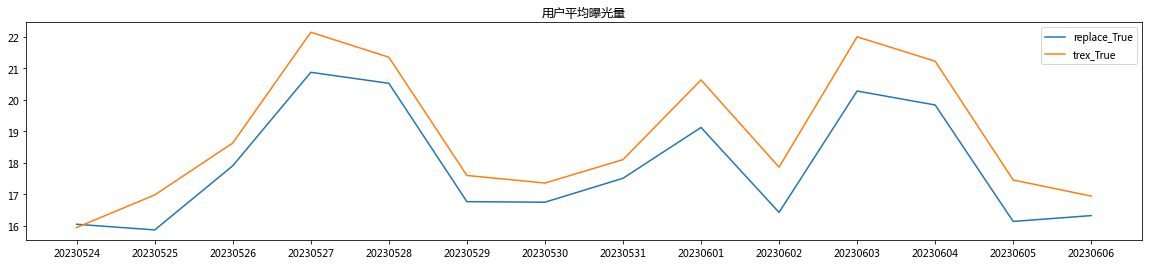

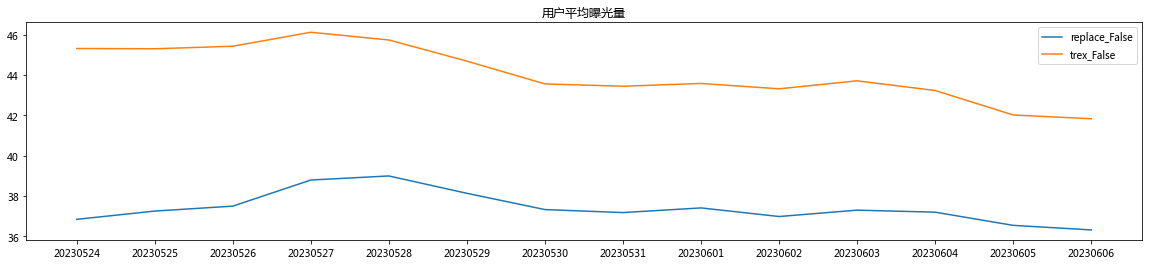

In [12]:
df = get_data_range("cold_user_pv_15_days", 14).reset_index().sort_values("date")
for is_cold in df.is_cold.unique():
    plt.figure(figsize=(20,4))   
    for algo_type in ['replace','trex']:
        tmp = df[(df.is_cold==is_cold)&(df.algo_type==algo_type)]
        plt.plot(tmp.date, tmp['mean'],label=algo_type+'_'+str(is_cold))
    plt.title("用户平均曝光量")
    plt.legend()
    plt.show()


# cold user 付费情况

In [9]:
def get_pay_data(target_date, date_range):
    pay_data = []
    for i in range(date_range):
        try:
            date = target_date - datetime.timedelta(i)
            path  = f'/data/gangyanyuan/data_rr/vod_ldd_ecpm_daily_details_rr/year={date.year}/month={date.month}/day={date.day}'
            data = pd.read_parquet(path)
            data['bucket'] = data.dnum.apply(lambda x: str(x)[-1])
            data['date'] = date.strftime("%Y%m%d")
            pay_data.append(data)
        except:
            print("load data error from,",date)
    pay_data = pd.concat(pay_data)
    return pay_data

In [32]:
pay_7 = get_pay_data(datetime.datetime.today() - datetime.timedelta(2), 7)

In [10]:
pay = get_pay_data(datetime.datetime.today() - datetime.timedelta(1), 1)

In [13]:
pay[pay.algo_type=='trex']

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date
31,579970216,TFeCYKBrqa1663811939782,【下滑更多↓】猜你喜欢：一次看过瘾,trex,xOIzDagDJw1612259932967,猫和老鼠-终极保镖,猫和老鼠之艺术天赋,"{0,9}",2023-05-16 21:07:35,1.00,套餐,0,1,500.0000,1.0000,1805293,0,1.000000,1.13819,2023-05-16 13:09:20,6,20230516
32,605067536,DZnXRryQAT1601214717245,【下滑更多↓】猜你喜欢：一次看过瘾,trex,dyILJGATFU1662601083618,小猪佩奇第9季,小猪佩奇第一季,"{0,0}",2023-05-16 11:39:35,28.00,套餐,1,1,48.1928,28.0000,1805293,0,28.000000,1.13819,2023-05-16 03:46:56,6,20230516
33,513154946,QWMpmfBmpL1653962424338,【下滑更多↓】猜你喜欢：一次看过瘾,trex,dzweDUESls1647418756548,宝宝巴士安全意识：我会注意安全,宝宝巴士奇妙大冒险,"{0,0}",2023-05-16 19:24:55,28.00,套餐,1,1,777.7778,28.0000,1805293,0,28.000000,1.13819,2023-05-16 11:25:47,6,20230516
34,543423293,CxMDwUWuSm1676613286593,【下滑更多↓】猜你喜欢：一次看过瘾,trex,MYqzwTgTUJ1670464318083,小志和玩具第二十季,小志和玩具第10季,"{0,5}",2023-05-16 17:18:04,9.90,套餐,1,1,65.5629,9.9000,1805293,0,9.900000,1.13819,2023-05-16 09:20:11,3,20230516
35,578302624,npGsKFjoSl1673427682482,【下滑更多↓】猜你喜欢：一次看过瘾,trex,JJjixZUQrC1681796566194,小公主和彩虹水果冰淇淋食玩,小公主小舞,"{0,3}",2023-05-16 17:22:09,89.00,套餐,1,1,366.2551,89.0000,1805293,0,89.000000,1.13819,2023-05-16 09:30:10,4,20230516
36,446508534,bEEhOnpmbd1672716920019,【下滑更多↓】猜你喜欢：一次看过瘾,trex,zOGXLpMHQc1612921864427,汪汪队立大功 第1季,汪汪队超威行动第二季,"{0,0}",2023-05-16 22:19:49,19.00,套餐,1,1,53.3708,19.0000,1805293,0,19.000000,1.13819,2023-05-16 14:21:22,4,20230516
37,510820317,DZnXRryQAT1601214717245,【下滑更多↓】猜你喜欢：一次看过瘾,trex,dyILJGATFU1662601083618,小猪佩奇第9季,小猪佩奇第一季,"{0,0}",2023-05-16 16:47:04,28.00,套餐,1,1,64.0732,28.0000,1805293,0,28.000000,1.13819,2023-05-16 08:54:01,7,20230516
38,512773410,ZFuEAGtOHx1629880899031,【下滑更多↓】猜你喜欢：一次看过瘾,trex,OqMoGDSgQv1673422634419,迷你小洞第三季,迷你小洞第二季,"{0,1}",2023-05-16 17:41:41,28.00,套餐,1,1,933.3333,28.0000,1805293,0,28.000000,1.13819,2023-05-16 09:45:08,0,20230516
39,612864653,WDDrnVqPnr1679021889595,【下滑更多↓】猜你喜欢：一次看过瘾,trex,doprEbqIMG1679021870345,超级飞侠第7季,超级飞侠第8季,"{0,0}",2023-05-16 17:23:48,55.00,套餐,1,1,647.0588,55.0000,1805293,0,55.000000,1.13819,2023-05-16 09:26:39,3,20230516
40,620886764,siQyOWEbNX1607669040844,【下滑更多↓】猜你喜欢：一次看过瘾,trex,rRwtzRXYAR1607669040844,毁灭地球的“终极病毒”,人体中强大的杀毒武器,"{0,2}",2023-05-16 20:48:50,66.00,套餐,1,1,7333.3333,66.0000,1805293,0,66.000000,1.13819,2023-05-16 12:50:50,4,20230516


In [50]:
ldd_cold = pd.read_parquet("/data/gangyanyuan/data_rr/ldd_cold_users/year=2023/month=5/day=16")

In [55]:
ldd_cold = pickle.load(open(f'../airflow_code/ldd_cold_user/20230516_cold_users.pkl','rb'))

In [35]:
pay_7[pay_7.algo_type=='replace'].groupby("cidName").income_filter.sum().reset_index().sort_values("income_filter",ascending=False).cidName.values

array(['超级宝贝JOJO', '兔子姐姐恐龙王国猜猜乐', '飞狗MOCO第二季', '宝贝赳赳 第四季', '兔小贝儿歌',
       '龙宝小英雄合集', '猪猪侠之竞速小英雄6', '奥特银河传说 外传 赛罗奥特曼黑暗洛普斯赛罗 第二季 赛罗的决死之战',
       '巴啦啦小魔仙之魔法星缘堡', '神兽金刚之超变星甲第二季', '吃豆小精灵第二季', '兔子姐姐早教儿童好习惯养成',
       '儿童迷你厨房乐园', '小志和玩具第二十季', '兔子姐姐早教启蒙思维认知游戏', '小仓鼠毛毛第二季', '猪屁登第一季（上）',
       '汽车世界之认车子学颜色', '贝乐虎童年经典儿歌', '汪汪队立大功 第1季', '兔子姐姐好习惯养成记',
       '汽车世界之工程车好伙伴', '托宝战士之战士觉醒', '汽车世界之超级越野车', '迷你特工队之超级恐龙力量',
       '动物世界之昆虫救援队', '赛罗奥特曼格斗 第二季', '白雪公主的奇幻之旅2023', '特工浣影之未解之谜',
       '捷德奥特曼剧场版 连接吧！心愿！！ 中配版', '小志和玩具第五季', '汽车世界之工程车好伙伴 第七季', '嘿基尼 第一季',
       '迷你特工队之X机甲剧场', '汽车世界之工程车好伙伴 第五季', '23号牛乃唐第一季', '新大头儿子和小头爸爸第四季',
       '小猴子萌萌', '迷你特工队 X', '益智宝贝', '汪汪队立大功全集', '汪汪队之超威救援先锋', '早教知识乐园',
       '萌鸡小队 第1季', '奥特银河格斗巨大阴谋中配版', '动物世界之认动物学颜色', '西游记（98版）',
       '请吃红小豆吧！第一季', '益智宝贝2023', '汽车世界之工程车好伙伴 第八季', '小猪佩奇第9季', '海绵宝宝第10季',
       '碰碰狐儿歌2（恐龙系列）', '汽车超级联盟', '汽车世界之工程车乐园 第二季', '汪汪队超能力', '宝贝赳赳 第五季',
       '咚咚动画屋之托宝战士 第一季', '咚咚益智园贝乐虎之超级汽车出动', '哈小浪欢乐校园', '战疫英雄', '小花仙 第一季',
       '泡泡美人鱼 第二季', '哪吒之

In [31]:
pay.groupby(["bucket","cidName"]).income_filter.sum().reset_index().sort_values("income_filter",ascending=False).groupby("bucket").cidName.unique().reset_index().set_index("bucket").to_dict()

{'cidName': {'0': array(['迷你小洞第二季', '巴啦啦小魔仙阿哦星球历险记', '汽车世界之工程车好伙伴', '坦克小英雄第二季', '超级宝贝JOJO'],
        dtype=object),
  '1': array(['超级宝贝JOJO'], dtype=object),
  '2': array(['小鸡彩虹英文版第二季（小鸡彩虹英文版）', '碰碰狐儿歌之鲨鱼宝宝系列英文版', '贝肯熊7', '奶龙'],
        dtype=object),
  '3': array(['工程车救援队 第三季', '汽车世界之玩具车总动员 第四季', '超级飞侠第8季', '汪汪队立大功 第1季',
         '汤姆猫家族疯狂跑酷', '小猪佩奇全集', '小志和玩具第10季', '宇宙护卫队之百变霸王龙 第2季',
         '喜羊羊与灰太狼之决战次时代', '小猴子啵啵'], dtype=object),
  '4': array(['小公主小舞', '人体中强大的杀毒武器', '迷你特工队之超级恐龙力量2', '超级宝贝JOJO第二季', '超级宝贝JOJO',
         '咚咚玩具屋工程车探险小队第二季', '贝肯熊第二季', '汪汪队超威行动第二季', '海绵宝宝 第3季', '爆笑虫子第三季上',
         '小猪佩奇全集', '奶龙搞怪大作战'], dtype=object),
  '5': array(['小猪佩奇全集', '舒克贝塔 第1季', '小猪佩奇第五季', '开心贝乐虎 第二季', '汽车世界之工程车好伙伴',
         '碰碰狐儿歌（鲨鱼宝宝系列）'], dtype=object),
  '6': array(['淘气包大卫系列', '超级飞侠第5季', '汽车世界之玩具车总动员', '小猪佩奇第一季', '宝宝巴士奇妙大冒险',
         '迷你特工队能量X战场', '迷你特工队特工帮帮忙', '坦克兄弟吃鸡动画第三季', '超级宝贝JOJO第二季',
         '动物兄弟 第五季', '奇妙萌可之闪亮宝石', '汪汪队立大功动画大乐园', '猫和老鼠之艺术天赋',
         '迷你特工队之超级恐龙力量'], dtype=objec

In [63]:
pay[pay.dnum.isin(ldd_cold['9'])]

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date
5,602227029,ANEqaPBcyO1604037148198,热播风向标：和全球小伙伴一起看,,piqlYHzTZH1636524606771,咚咚玩具屋汽车世界拼搭工程车,汽车世界之玩具车总动员,"{0,5}",2023-05-16 16:23:18,55.00,套餐,0,2,None,None,1462294,0,55.0,0.349383,2023-05-16 08:25:51,9,20230516
26,602803729,FMwztgMWvH1653889355261,【下滑更多↓】猜你喜欢：一次看过瘾,replace,cpTksMugnu1653891844798,宝宝巴士英文儿歌,宝宝巴士语言表达：宝宝学古诗,"{0,2}",2023-05-16 17:21:12,19.00,套餐,1,1,9500.0000,19.0000,361549,0,19.0,0.268935,2023-05-16 09:29:52,9,20230516


In [60]:
pay[pay.dnum.isin(ldd_cold['7'])]

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date
37,510820317,DZnXRryQAT1601214717245,【下滑更多↓】猜你喜欢：一次看过瘾,trex,dyILJGATFU1662601083618,小猪佩奇第9季,小猪佩奇第一季,"{0,0}",2023-05-16 16:47:04,28.00,套餐,1,1,64.0732,28.0000,1805293,0,28.0,1.13819,2023-05-16 08:54:01,7,20230516
47,544840197,WtQiXszITT1628070668771,【下滑更多↓】猜你喜欢：一次看过瘾,trex,dyILJGATFU1662601083618,小猪佩奇第9季,小猪佩奇第八季,"{0,4}",2023-05-16 10:20:58,55.00,套餐,1,1,1057.6923,55.0000,1805293,0,55.0,1.13819,2023-05-16 02:21:58,7,20230516
53,562412187,pbKdDKcYZQ1672826029738,【下滑更多↓】猜你喜欢：一次看过瘾,trex,tKAiLzMLOf1636358515487,汽车世界之车宝英雄,汽车世界之车宝英雄 第四季,"{0,3}",2023-05-16 12:14:24,55.00,套餐,1,1,7857.1429,55.0000,1805293,0,55.0,1.13819,2023-05-16 04:18:30,7,20230516
72,561150687,HQxPqhSsuF1598351177549,【下滑更多↓】猜你喜欢：一次看过瘾,trex,LSnIychNkY1639040606959,贝乐虎之超级汽车 第二季,贝乐虎儿童音乐剧之超级汽车,"{0,1}",2023-05-16 18:22:00,1.00,套餐,0,1,5.7803,1.0000,1805293,0,1.0,1.13819,2023-05-16 10:29:19,7,20230516


In [61]:
pay[pay.dnum.isin(ldd_cold['6'])]

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date
0,577759326,COPAnoLLWG1605582357423,热播风向标：和全球小伙伴一起看,,HQxPqhSsuF1598351177549,贝乐虎儿童音乐剧之超级汽车,迷你特工队之超级恐龙力量,"{0,5}",2023-05-16 11:55:27,1.00,套餐,1,1,None,None,1462294,0,1.0,0.349383,2023-05-16 00:59:45,6,20230516
15,525684426,TWLFYaSwzS1615262192462,热播风向标：和全球小伙伴一起看,,dyILJGATFU1662601083618,小猪佩奇第9季,超级宝贝JOJO第二季,"{0,0}",2023-05-16 21:55:16,9.90,套餐,1,1,None,None,1462294,0,9.9,0.349383,2023-05-16 14:01:15,6,20230516
31,579970216,TFeCYKBrqa1663811939782,【下滑更多↓】猜你喜欢：一次看过瘾,trex,xOIzDagDJw1612259932967,猫和老鼠-终极保镖,猫和老鼠之艺术天赋,"{0,9}",2023-05-16 21:07:35,1.00,套餐,0,1,500.0000,1.0000,1805293,0,1.0,1.138190,2023-05-16 13:09:20,6,20230516
55,577814016,saPqidlzFM1623226261705,【下滑更多↓】猜你喜欢：一次看过瘾,trex,DVnOIQRNcb1636635455424,大卫惹麻烦,淘气包大卫系列,"{0,0}",2023-05-16 19:11:10,269.00,套餐,1,1,12809.5238,269.0000,1805293,0,269.0,1.138190,2023-05-16 11:12:40,6,20230516
61,589447126,ASAStUhOzd1679021778296,【下滑更多↓】猜你喜欢：一次看过瘾,trex,OedKlkIXlp1620635738569,超级飞侠第9季,超级飞侠第5季,"{0,2}",2023-05-16 17:28:17,269.00,套餐,1,1,7078.9474,269.0000,1805293,0,269.0,1.138190,2023-05-16 09:28:54,6,20230516
65,532982236,XJmOeTbuyE1660813189140,【下滑更多↓】猜你喜欢：一次看过瘾,trex,LYBWueiSVs1654910640173,小猴子啵啵,汪汪队立大功动画大乐园,"{0,5}",2023-05-16 19:45:29,1.00,套餐,0,1,4.6729,1.0000,1805293,0,1.0,1.138190,2023-05-16 11:51:29,6,20230516
66,613479116,wgIKFPmLDT1611063103801,【下滑更多↓】猜你喜欢：一次看过瘾,trex,QsgfRBBdAu1640917420445,动物兄弟第六季,动物兄弟 第五季,"{0,0}",2023-05-16 07:50:18,1.00,套餐,1,1,28.5714,1.0000,1805293,0,1.0,1.138190,2023-05-15 23:57:19,6,20230516
71,441836266,VnukKzayCX1672030917761,【下滑更多↓】猜你喜欢：一次看过瘾,trex,xGOuQqrDhj1672030794752,奇妙萌可之闪亮宝石预告片,奇妙萌可之闪亮宝石,"{0,0}",2023-05-16 19:05:30,1.00,套餐,0,1,10.3093,1.0000,1805293,0,1.0,1.138190,2023-05-16 11:08:01,6,20230516


In [76]:
def show_result(path):
    result = {}
    with open(path,'r') as f:
        for line in f.readlines():
            try:
                data= line.split('\t')
                aid = re.split(r"_+", data[0])
                aid = aid[0]
                sims = json.loads(data[1])
                cids=[re.split(r"_+", sim)[0] for sim in sims]
                scores = [re.split(r"_+", sim)[-1] for sim in sims]
                result[aid]= dict(zip(cids,scores)) 
            except:
                continue
    print(len(result))
    return result

r6 = show_result('/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/recall_result/child/20230516_6.csv')
r6_cold = show_result('/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/recall_result/child/20230516_6_cold.csv')

r5 = show_result('/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/recall_result/child/20230516_5.csv')
r7 = show_result('/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/recall_result/child/20230516_7.csv')


14591
14591
14591
14591


In [96]:
r7_yes = show_result('/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/recall_result/child/20230515_7.csv')

14552


In [89]:
aid_title = dict(zip(media.aid, media.title))

In [95]:
for bucket in ['0','2','3','4','5']:
    print(bucket)
    for base in pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')].baseCid:
        print(aid_title.get(base))
        cids = pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')&(pay.baseCid==base)].cid.tolist()
        print( {aid_title.get(cid):r6[base].get(cid,'') for cid in cids} )

0
2
熊熊乐园第四季预告片
{'贝肯熊7': 'csgl'}
3
小志和玩具第二十季
{'小志和玩具第10季': 'title'}
汪汪队之超威救援先锋
{'汪汪队立大功 第1季': 'csgl#online'}
喜羊羊与灰太狼之勇闯四季城
{'喜羊羊与灰太狼之决战次时代': 'csgl#title#online7days#online'}
4
汪汪队立大功 第1季
{'汪汪队超威行动第二季': 'csgl#paid1#online'}
迷你特工队之兽王力量
{'迷你特工队之超级恐龙力量2': 'csgl#title#paid3#online'}
海绵宝宝 第2季
{'海绵宝宝 第3季': 'csgl#ip#itemcf#online7days#online'}
贝肯熊第一季
{'贝肯熊第二季': 'csgl#ip#online'}
爆笑虫子第一季
{'爆笑虫子第三季上': 'csgl#title#online7days#online'}
5
开心贝乐虎
{'开心贝乐虎 第二季': 'csgl#itemcf#online'}
小猪佩奇第八季预告片
{'小猪佩奇全集': 'csgl#paid3#online'}
碰碰狐儿歌之鲨鱼宝宝系列英文版
{'碰碰狐儿歌（鲨鱼宝宝系列）': 'ip'}


In [94]:
for bucket in ['0','2','3','4','5']:
    print(bucket)
    for base in pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')].baseCid:
        print(aid_title.get(base))
        cids = pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')&(pay.baseCid==base)].cid.tolist()
        print( {aid_title.get(cid):r6_cold[base].get(cid,'') for cid in cids} )

0
2
熊熊乐园第四季预告片
{'贝肯熊7': ''}
3
小志和玩具第二十季
{'小志和玩具第10季': 'lightgcl#title'}
汪汪队之超威救援先锋
{'汪汪队立大功 第1季': 'lightgcl#online'}
喜羊羊与灰太狼之勇闯四季城
{'喜羊羊与灰太狼之决战次时代': 'lightgcl#title#online7days#online'}
4
汪汪队立大功 第1季
{'汪汪队超威行动第二季': 'paid1#online'}
迷你特工队之兽王力量
{'迷你特工队之超级恐龙力量2': 'lightgcl#title#paid3#online'}
海绵宝宝 第2季
{'海绵宝宝 第3季': 'ip#itemcf#online7days#online'}
贝肯熊第一季
{'贝肯熊第二季': 'lightgcl#ip#online'}
爆笑虫子第一季
{'爆笑虫子第三季上': 'lightgcl#title#online7days#online'}
5
开心贝乐虎
{'开心贝乐虎 第二季': 'lightgcl#itemcf#online'}
小猪佩奇第八季预告片
{'小猪佩奇全集': 'paid3#online'}
碰碰狐儿歌之鲨鱼宝宝系列英文版
{'碰碰狐儿歌（鲨鱼宝宝系列）': 'ip'}


In [104]:
for bucket in ['7']:
    print(bucket)
    for base in pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')].baseCid:
        print(aid_title.get(base))
        cids = pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')&(pay.baseCid==base)].cid.tolist()
        print( {aid_title.get(cid):r7[base].get(cid,'') for cid in cids} )
        print('------')
        print( {aid_title.get(cid):r7_yes[base].get(cid,'') for cid in cids} )
        print(bucket_7_replace.get(base,[]))
        print()

7
小猪佩奇第9季
{'小猪佩奇第一季': 'sgl#title#paid1#paid3#online', '小猪佩奇第八季': ''}
------
{'小猪佩奇第一季': 'sgl#title#paid1#paid3#online', '小猪佩奇第八季': 'sgl#title#paid1#online'}
[]

小猪佩奇第9季
{'小猪佩奇第一季': 'sgl#title#paid1#paid3#online', '小猪佩奇第八季': ''}
------
{'小猪佩奇第一季': 'sgl#title#paid1#paid3#online', '小猪佩奇第八季': 'sgl#title#paid1#online'}
[]

汽车世界之车宝英雄
{'汽车世界之车宝英雄 第四季': 'sgl#itemcf'}
------
{'汽车世界之车宝英雄 第四季': 'sgl#itemcf#online'}
[]

贝乐虎之超级汽车 第二季
{'贝乐虎儿童音乐剧之超级汽车': 'sgl#ip#itemcf#paid3#online'}
------
{'贝乐虎儿童音乐剧之超级汽车': 'sgl#ip#paid3#online'}
[]



In [109]:
bucket_7_replace[base],bucket_cold_replace[base],bucket_replace[base]

KeyError: 'LSnIychNkY1639040606959'

In [108]:
bucket_replace = pickle.load(open("/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/replace_recall/20230516.pkl",'rb'))
bucket_cold_replace = pickle.load(open("/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/replace_recall/20230516_cold.pkl",'rb'))

In [ ]:
bucket_7_replace = pickle.load(open("/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/replace_recall/20230516_bucket7.pkl",'rb'))

In [101]:
bucket_7_replace = pickle.load(open("/data/gangyanyuan/recommender_system_recall_vod/ldd_recall/data/replace_recall/20230516_bucket7.pkl",'rb'))

In [92]:
for bucket in ['6']:
    print(bucket)
    for base in pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')].baseCid:
        print(aid_title.get(base))
        cids = pay[pay.dnum.isin(ldd_cold[bucket])&(pay.algo_type=='trex')&(pay.baseCid==base)].cid.tolist()
        print({aid_title.get(cid):r5[base].get(cid,'') for cid in cids})

6
猫和老鼠-终极保镖
{'猫和老鼠之艺术天赋': 'sgl'}
大卫惹麻烦
{'淘气包大卫系列': 'sgl#title#itemcf#online'}
超级飞侠第9季
{'超级飞侠第5季': 'sgl#itemcf#online'}
小猴子啵啵
{'汪汪队立大功动画大乐园': 'paid3'}
动物兄弟第六季
{'动物兄弟 第五季': 'sgl#ip#itemcf#online'}
奇妙萌可之闪亮宝石预告片
{'奇妙萌可之闪亮宝石': 'sgl#title#itemcf#paid1#online'}


In [67]:
pay[pay.dnum.isin(list(ldd_cold['0']))]

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date
16,540728020,OZGFxJdCEA1604037148197,热播风向标：和全球小伙伴一起看,,TxwHaxEqjm1678941730402,汽车世界之工程车好伙伴 第九季,汽车世界之工程车好伙伴,"{0,4}",2023-05-16 10:31:44,19.00,套餐,1,1,None,None,1462294,0,19.0,0.349383,2023-05-16 02:44:18,0,20230516


In [166]:
cids_pv = []
for i in range(14):
    date = (datetime.datetime.today() - datetime.timedelta(i+1)).strftime("%Y%m%d")
    data = pd.read_parquet(f"/data/gangyanyuan/liubing/vod_analysis/airflow_code/basecid_cid_performace_group/ldd/{date}/cid_group.parquet")
    cids_pv.append(data)

cids_pv = pd.concat(cids_pv)   
cids_pv = cids_pv.groupby("cid").agg({"click_pv":sum, "show_pv":sum}).reset_index()

In [175]:
cids_pv_replace = []
for i in range(14):
    date = (datetime.datetime.today() - datetime.timedelta(i+1)).strftime("%Y%m%d")
    data = pd.read_parquet(f"/data/gangyanyuan/liubing/vod_analysis/airflow_code/basecid_cid_performace_group/ldd_replace/{date}/cid_group.parquet")
    cids_pv_replace.append(data)

cids_pv_replace = pd.concat(cids_pv_replace)   
cids_pv_replace = cids_pv_replace.groupby("cid").agg({"click_pv":sum, "show_pv":sum}).reset_index()

In [167]:
cids_pv.head()

,cid,click_pv,show_pv
0,AAtlSyBxtN1629956779193,2,61
1,ABYCKGWVAr1621240012639,4,124
2,ABqQXLmYZl1623226259422,48,538
3,ABxfJzjfqx1627638201438,0,1
4,ADGYhmdhrn1681785580205,28,120


In [176]:
pay_replace = pay[pay.algo_type=='replace']
pay_replace_cid = pay_replace.groupby(['cid','cidName']).agg({"income_filter":sum}).reset_index().sort_values(['income_filter'],ascending=False)
pay_replace_cid.head(20)

,cid,cidName,income_filter
76,dNUkdLPkci1585650051748,超级宝贝JOJO,410.000000
74,booCmTupLt1617335839554,汪汪队立大功之超能救援,284.500000
117,vzzioKATQa1681268791040,兔子姐姐恐龙王国猜猜乐,269.000000
52,UmbJnWWpCL1673509385238,布鲁可战队第三季,249.000000
9,EtoGwzMkmD1673259220418,奶龙搞怪大作战,239.000000
49,UGvLvqRSzd1603097958878,海底小纵队第四季,229.000000
65,ZUFQzIPCcF1629290662965,JoJo英语启蒙,229.000000
104,pnbLavCsbd1638494905392,飞狗MOCO第二季,229.000000
110,sTuXtscHGg1660283881528,宝贝赳赳 第四季,213.000000
122,yIxyNQnmRO1604641798409,兔小贝儿歌,181.900000


In [181]:
replace_cid_per.head()

,cid,cidName,income_filter,click_pv,show_pv,ecpm
0,dNUkdLPkci1585650051748,超级宝贝JOJO,410.0,3871,53388,7.679628
1,booCmTupLt1617335839554,汪汪队立大功之超能救援,284.5,1721,9407,30.243436
2,vzzioKATQa1681268791040,兔子姐姐恐龙王国猜猜乐,269.0,3301,15536,17.314624
3,UmbJnWWpCL1673509385238,布鲁可战队第三季,249.0,302,2108,118.121442
4,EtoGwzMkmD1673259220418,奶龙搞怪大作战,239.0,3163,20043,11.924363


In [182]:
trex_cid_per.head()

,cid,cidName,income_filter,click_pv,show_pv,ecpm
0,DZnXRryQAT1601214717245,小猪佩奇第一季,524.8,16517,91038,5.764626
1,KWSllIzJXw1658988371265,魔法学院第一季破蛹成蝶,492.0,2352,16037,30.679055
2,wfpGEbJzog1599120789032,我的汤姆猫短片,439.0,2293,28801,15.242526
3,bEEhOnpmbd1672716920019,汪汪队超威行动第二季,430.5,16707,116645,3.690685
4,xgqXBaHvwo1657158789697,宝贝佑佑之工程车家族,411.5,2000,17579,23.408613


In [206]:
trex_cid_per[trex_cid_per.cid.isin(replace_cid_per.cid)].income_filter.mean()/replace_cid_per[replace_cid_per.cid.isin(trex_cid_per.cid)].income_filter.mean()

1.6954923083918216

In [216]:
trex_cid_per[trex_cid_per.cid.isin(replace_cid_per.cid)].show_pv.mean()/replace_cid_per[replace_cid_per.cid.isin(trex_cid_per.cid)].show_pv.mean()

2.7474453043495166

In [217]:
trex_cid_per[~trex_cid_per.cid.isin(replace_cid_per.cid)].income_filter.sum()/replace_cid_per[~replace_cid_per.cid.isin(trex_cid_per.cid)].income_filter.sum()

6.757648097743203

In [218]:
trex_cid_per[~trex_cid_per.cid.isin(replace_cid_per.cid)].show_pv.sum()/replace_cid_per[~replace_cid_per.cid.isin(trex_cid_per.cid)].show_pv.sum()

24.9774325385494

In [201]:
trex_cid_per[~trex_cid_per.cid.isin(replace_cid_per.cid)]

,cid,cidName,income_filter,click_pv,show_pv,ecpm
0,DZnXRryQAT1601214717245,小猪佩奇第一季,524.8,16517,91038,5.764626
1,KWSllIzJXw1658988371265,魔法学院第一季破蛹成蝶,492.0,2352,16037,30.679055
2,wfpGEbJzog1599120789032,我的汤姆猫短片,439.0,2293,28801,15.242526
3,bEEhOnpmbd1672716920019,汪汪队超威行动第二季,430.5,16707,116645,3.690685
4,xgqXBaHvwo1657158789697,宝贝佑佑之工程车家族,411.5,2000,17579,23.408613
...,...,...,...,...,...,...
422,TScckgolHu1676272271292,迷你小洞第3季,1.0,3040,20470,0.048852
424,kazAhABLJW1638266339236,彩虹宝宝短视频之彼彼鸟,1.0,582,7319,0.136631
425,lDHJynRRZJ1609846108313,愤怒的小鸟之猪猪传第四季,1.0,320,3319,0.301296
426,SuKxeamJYx1680597340876,神奇的朋友2（上）咖宝车神,1.0,4030,30125,0.033195


In [192]:
replace_cid_per[replace_cid_per.cid.isin(trex_cid_per.cid)].show_pv.describe()

count       63.000000
mean     14697.492063
std      11732.622054
min        466.000000
25%       6348.000000
50%      11384.000000
75%      19507.000000
max      53388.000000
Name: show_pv, dtype: float64

In [183]:
trex_cid_per[trex_cid_per.cid.isin(replace_cid_per.cid)].ecpm.describe()

count    63.000000
mean      2.831436
std       3.288326
min       0.041938
25%       0.736635
50%       1.683535
75%       3.591936
max      14.793573
Name: ecpm, dtype: float64

In [185]:
replace_cid_per[replace_cid_per.cid.isin(trex_cid_per.cid)].ecpm.describe()

count    63.000000
mean      7.199970
std       9.654731
min       0.046189
25%       1.469932
50%       2.753196
75%       8.036457
max      40.772532
Name: ecpm, dtype: float64

In [184]:
trex_cid_per[~trex_cid_per.cid.isin(replace_cid_per.cid)].ecpm.describe()

count     365.000000
mean        8.570410
std       107.999560
min         0.012015
25%         0.426411
50%         1.135580
75%         2.653446
max      2061.538462
Name: ecpm, dtype: float64

In [186]:
replace_cid_per[~replace_cid_per.cid.isin(trex_cid_per.cid)].ecpm.describe()

count     66.000000
mean      16.625782
std       37.259072
min        0.066476
25%        1.511420
50%        5.245516
75%       13.627464
max      242.841994
Name: ecpm, dtype: float64

In [179]:
replace_cid_per = pd.merge(pay_replace_cid, cids_pv_replace,on='cid')
replace_cid_per['ecpm'] = replace_cid_per.income_filter/replace_cid_per.show_pv*1000
replace_cid_per[replace_cid_per['ecpm']>1].ecpm.describe()


count    106.000000
mean      14.533028
std       30.099704
min        1.162984
25%        2.112202
50%        5.364793
75%       15.274071
max      242.841994
Name: ecpm, dtype: float64

In [171]:
pay_trex = pay[pay.algo_type=='trex']
pay_trex_cid = pay_trex.groupby(['cid','cidName']).agg({"income_filter":sum}).reset_index().sort_values(['income_filter'],ascending=False)
pay_trex_cid.head(20)

,cid,cidName,income_filter
34,DZnXRryQAT1601214717245,小猪佩奇第一季,524.800000
91,KWSllIzJXw1658988371265,魔法学院第一季破蛹成蝶,492.000000
402,wfpGEbJzog1599120789032,我的汤姆猫短片,439.000000
230,bEEhOnpmbd1672716920019,汪汪队超威行动第二季,430.500000
412,xgqXBaHvwo1657158789697,宝贝佑佑之工程车家族,411.500000
92,KcLUnaQzax1682498008320,兔子姐姐早教儿童好习惯养成,393.000000
163,TWLFYaSwzS1615262192462,超级宝贝JOJO第二季,355.833333
400,wdIZnLoVAZ1637670631371,汽车世界之工程车好伙伴 第3季,331.916667
235,bkHXBHEHSd1672803042858,喜羊羊与灰太狼之勇闯四季城,325.000000
9,BGwYVyWFTD1624959230250,萌鸡小队 第1季,318.333333


In [180]:
trex_cid_per = pd.merge(pay_trex_cid, cids_pv,on='cid')
trex_cid_per['ecpm'] = trex_cid_per.income_filter/trex_cid_per.show_pv*1000
trex_cid_per[trex_cid_per['ecpm']>1].ecpm.describe()

count     244.000000
mean       13.238481
std       131.950146
min         1.006819
25%         1.462658
50%         2.537333
75%         4.890685
max      2061.538462
Name: ecpm, dtype: float64

In [211]:
replace_cid_per1 = pd.merge(pay_replace_cid, cids_pv_replace,on='cid',how='right')
replace_cid_per1['ecpm'] = replace_cid_per1.income_filter/replace_cid_per1.show_pv*1000
replace_cid_per1[replace_cid_per1.ecpm.isna()].show_pv.sum()/14

382238.5714285714

In [210]:
trex_cid_per1 = pd.merge(pay_trex_cid, cids_pv,on='cid',how='right')
trex_cid_per1['ecpm'] = trex_cid_per1.income_filter/trex_cid_per1.show_pv*1000
trex_cid_per1[trex_cid_per1.ecpm.isna()].show_pv.sum()/14

1413235.357142857

In [215]:
1413235.357142857/382238.5714285714

3.6972599386321927

In [156]:
pay_trex_cid[pay_trex_cid.cidName.isin(pay_replace_cid.head(20).cidName)]

,cidName,col_algo_eps_pv,income_filter,ecpm
33,兔子姐姐早教儿童好习惯养成,5190401,393.000000,0.075717
93,奶龙搞怪大作战,32930214,263.266667,0.007995
32,兔子姐姐恐龙王国猜猜乐,15491521,258.000000,0.016654
369,超级宝贝JOJO,40065849,191.250000,0.004773
286,猪猪侠之竞速小英雄6,10969849,179.000000,0.016317
224,汪汪队立大功 第1季,17302268,175.000000,0.010114
234,汽车世界之工程车好伙伴 第九季,11366200,150.583333,0.013248
225,汪汪队立大功之超能救援,23250034,85.166667,0.003663
115,宝贝赳赳 第四季,7181849,56.900000,0.007923
236,汽车世界之工程车好伙伴 第五季,5125018,34.100000,0.006654


In [129]:
cold_user = pd.read_parquet("/data/gangyanyuan/data_rr/ldd_cold_users/year=2023/month=5/day=9")
cold_user.head(3)

,dnum,bucket
0,592032227,7
1,577075976,6
2,619037894,4


In [130]:
pay[pay.dnum.isin(cold_user.dnum)]

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,bucket,date


In [ ]:
pay[pay.dnum.isin(cold_user.dnum)]

# get data

In [3]:
def get_dnum_eps_ndays(date_range):
    
    data_dnum = []

    for i in range(date_range):
        date = datetime.datetime.today() -datetime.timedelta(i+1)
        log = pd.read_parquet(f"/data/gangyanyuan/data_rr/user_click_exposure_video_raw_ldd_rr/year={date.year}/month={date.month}/day={date.day}")
        log = pd.merge(log, media[['aid']],left_on='baseCid',right_on="aid")
        log = log[log.algo_type!='']
        dnum = log.groupby(["dnum","activeName","algo_type"]).agg({"cid":"count"}).reset_index()
        dnum = pd.pivot(dnum, index=["dnum","algo_type"],columns=['activeName'],values=['cid']).reset_index()
        dnum['date'] = date.strftime("%Y%m%d")
        data_dnum.append(dnum)
        del log,dnum
    data_dnum = pd.concat(data_dnum)
    data_dnum.columns=['dnum','algo_type','clk_pv','show_pv','date']
    return data_dnum


In [4]:
data_dnum = get_dnum_eps_ndays(17)

In [ ]:
data_dnum.head(5)

In [5]:
data_dnum['bucket'] = data_dnum.dnum.apply(lambda x: str(x)[-1] if len(x)>0 else '')

In [6]:
def get_pay_data(date_range):
    pay_data = []
    for i in range(date_range):
        date = datetime.datetime.today() - datetime.timedelta(i+1)
        path  = f'/data/gangyanyuan/data_rr/vod_ldd_ecpm_daily_details_rr/year={date.year}/month={date.month}/day={date.day}'
        data = pd.read_parquet(path)
        data['bucket'] = data.dnum.apply(lambda x: str(x)[-1])
        data['date'] = date.strftime("%Y%m%d")
        pay_data.append(data)
    pay_data = pd.concat(pay_data)
    return pay_data
    

In [26]:
32.4/(32.4+128.4),(9.07-8.84)/8.84*100

(0.2014925373134328, 2.601809954751136)

In [7]:
pay_data = get_pay_data(17)

# 没有出现在前7天的用户在当天的用户占比, 冷启动用户占比

In [8]:
def get_dnum_per_not_appear_in_last_ndays(data, target_date,n):
    
    date_start = (datetime.datetime.strptime(target_date,"%Y%m%d")- datetime.timedelta(n)).strftime("%Y%m%d")
    def cpr(x,target_date,n):
        if x==target_date:
            return True
        elif x<target_date and x>=date_start:
            return False
        else:
            return ''
        
    data['is_target_day'] = data.date.apply(lambda x: cpr(x,target_date,n))
    data = data[data.is_target_day!='']
    data = data.groupby(["is_target_day","bucket"]).dnum.unique().reset_index()
    data['dnum_size'] = data.dnum.apply(len)
    data_bucket = pd.pivot(data,index=['bucket'],columns=['is_target_day'],values=['dnum','dnum_size']).reset_index()
    data_bucket.columns=['bucket','历史N天用户','当天用户',"历史N天用户数量",'当天用户数量']

    data_bucket['当天冷启动用户'] = data_bucket[['历史N天用户','当天用户']].apply(lambda x:set(x.当天用户)- set(x.历史N天用户) ,axis=1)
    data_bucket['当天冷启动用户数量'] = data_bucket.当天冷启动用户.apply(len)
    
    data_bucket['当天冷启动用户数量'] = data_bucket.当天冷启动用户数量.fillna(0)
    data_bucket['当天用户数量'] = data_bucket.当天用户数量.fillna(0)
    data_bucket['当天冷启动用户占比'] = data_bucket.当天冷启动用户数量/(data_bucket.当天用户数量+1e-9)*100
    return data_bucket

In [9]:
dnum_bucket = get_dnum_per_not_appear_in_last_ndays(data_dnum, '20230302',14)

In [30]:
dnum_bucket

,bucket,历史N天用户,当天用户,历史N天用户数量,当天用户数量,当天冷启动用户,当天冷启动用户数量,当天冷启动用户占比
0,0,"[106446530, 424064390, 424692140, 425171780, 4...","[106446530, 424692140, 425279660, 425451660, 4...",64285,6321,"{447621650, 513159100, 513617880, 552941210, 5...",2039,32.257554
1,1,"[562481771, 564717731, 564766121, 565062381, 5...","[563109401, 563650911, 564708981, 564717731, 5...",162,16,"{569286361, 563650911, 622323911, 568272361, 5...",6,37.500000
2,2,"[424522902, 424685142, 425216512, 425301862, 4...","[424123522, 424685142, 425579232, 425631452, 4...",66973,6916,"{609350712, 543937302, 588547042, 510770272, 5...",2067,29.887218
3,3,"[106447493, 414166133, 414170083, 414179503, 4...","[106447493, 414179503, 414208963, 414222733, 4...",65480,6519,"{539413433, 533590433, 583524243, 610826563, 5...",1933,29.651787
4,4,"[106446864, 106448104, 424586054, 424671014, 4...","[106446864, 424121124, 425238244, 425450954, 4...",65534,6442,"{511813624, 616530724, 614116034, 562340004, 5...",1994,30.953120
5,5,"[414159805, 414180775, 414188605, 414229155, 4...","[414159805, 414178055, 414180015, 414188605, 4...",64998,6461,"{527186945, 543604195, 603289125, 570932895, 5...",2048,31.697880
6,6,"[150859616, 424617286, 424659986, 425155156, 4...","[424617286, 425228836, 425300196, 425489606, 4...",63845,6450,"{606166706, 617604886, 546412186, 605330376, 5...",2018,31.286822
7,7,"[414221507, 414244897, 424551817, 424700247, 4...","[414160047, 414176957, 414187397, 414244897, 4...",63722,6242,"{515720697, 537582597, 534353057, 604875407, 5...",1917,30.711310
8,8,"[106447408, 424566528, 424636468, 424647948, 4...","[106447408, 424510698, 424608798, 425494228, 4...",62203,5704,"{572536798, 575420118, 596077208, 525725958, 6...",1827,32.030154
9,9,"[106446719, 414176649, 414188649, 414245129, 4...","[106447599, 414180309, 414245129, 425185469, 4...",62995,5929,"{571508459, 579661369, 587850239, 521637379, 5...",1969,33.209647


In [10]:
dnum_cold = dict(zip(dnum_bucket.bucket,dnum_bucket.当天冷启动用户))

In [11]:
pay_bucket = get_dnum_per_not_appear_in_last_ndays(pay_data[pay_data.bucket!='1'], '20230302',14)

/data/dev/miniconda/envs/recsys2/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [27]:
pay_bucket

,bucket,历史N天用户,当天用户,历史N天用户数量,当天用户数量,当天冷启动用户,当天冷启动用户数量,当天冷启动用户占比
0,0,"[518346230, 603759390, 613597210, 583969520, 4...","[514221030, 609435840, 543661020, 614611250, 5...",143,8,"{562251680, 514221030, 609435840, 512910700, 5...",8,100.0
1,2,"[557026082, 567408142, 628315072, 593232242, 6...","[521757702, 575545832, 579645852, 458306682, 5...",133,7,"{458306682, 541781652, 579645852, 521757702, 5...",7,100.0
2,3,"[613746533, 539420043, 455529113, 522573733, 5...","[601790783, 526081863, 581281283, 533052463, 6...",154,6,"{533052463, 526081863, 624640763, 581281283, 6...",6,100.0
3,4,"[577191964, 522574184, 514308534, 570173554, 5...","[624714244, 581791244, 611181554, 522325924, 6...",145,7,"{610288304, 611181554, 518961144, 581791244, 4...",7,100.0
4,5,"[587780935, 443595445, 581057955, 517151715, 5...","[611993895, 586390865, 512817085, 512984465]",139,4,"{611993895, 512984465, 512817085, 586390865}",4,100.0
5,6,"[581128626, 447622666, 522949776, 518242956, 5...","[516948676, 520295936, 613215986, 611337036, 5...",167,8,"{516948676, 520295936, 534324036, 565275066, 5...",8,100.0
6,7,"[623231617, 555093317, 524388077, 573988287, 4...","[579709817, 517404907, 570727837, 613440257, 5...",145,7,"{558891197, 615551567, 537039247, 579709817, 5...",7,100.0
7,8,"[578192488, 611381368, 540829998, 517177528, 6...","[537019368, 512615218, 610298328, 518981578, 6...",140,9,"{621771498, 512615218, 518981578, 562248198, 5...",9,100.0
8,9,"[591741889, 516053179, 577740109, 607807609, 5...","[594878429, 556413159, 590000979, 446474199, 5...",143,11,"{594878429, 581074539, 622579839, 556413159, 5...",11,100.0


In [12]:
pay_dnum = pd.merge(pay_bucket,dnum_bucket,on='bucket',suffixes=['_付费','_曝光'])

In [13]:
pay_dnum['当天有付费行为的曝光冷启动用户数量'] = pay_dnum[['当天冷启动用户_曝光','当天用户_付费']].apply(lambda x:\
                                                                                                  len(set(x.当天冷启动用户_曝光) & set(x.当天用户_付费)),\
                                                                                                        axis=1)

pay_dnum['当天曝光冷启动用户中,付费用户占比%'] = pay_dnum.当天有付费行为的曝光冷启动用户数量/pay_dnum.当天冷启动用户数量_曝光*100
pay_dnum['当天付费用户中,曝光冷启动用户占比%'] = pay_dnum.当天有付费行为的曝光冷启动用户数量/pay_dnum.当天用户数量_付费*100

pay_dnum


,bucket,历史N天用户_付费,当天用户_付费,历史N天用户数量_付费,当天用户数量_付费,当天冷启动用户_付费,当天冷启动用户数量_付费,当天冷启动用户占比_付费,历史N天用户_曝光,当天用户_曝光,历史N天用户数量_曝光,当天用户数量_曝光,当天冷启动用户_曝光,当天冷启动用户数量_曝光,当天冷启动用户占比_曝光,当天有付费行为的曝光冷启动用户数量,"当天曝光冷启动用户中,付费用户占比%","当天付费用户中,曝光冷启动用户占比%"
0,0,"[518346230, 603759390, 613597210, 583969520, 4...","[514221030, 609435840, 543661020, 614611250, 5...",143,8,"{562251680, 514221030, 609435840, 512910700, 5...",8,100.0,"[106446530, 424064390, 424692140, 425171780, 4...","[106446530, 424692140, 425279660, 425451660, 4...",64285,6321,"{447621650, 513159100, 513617880, 552941210, 5...",2039,32.257554,3,0.147131,37.500000
1,2,"[557026082, 567408142, 628315072, 593232242, 6...","[521757702, 575545832, 579645852, 458306682, 5...",133,7,"{458306682, 541781652, 579645852, 521757702, 5...",7,100.0,"[424522902, 424685142, 425216512, 425301862, 4...","[424123522, 424685142, 425579232, 425631452, 4...",66973,6916,"{609350712, 543937302, 588547042, 510770272, 5...",2067,29.887218,4,0.193517,57.142857
2,3,"[613746533, 539420043, 455529113, 522573733, 5...","[601790783, 526081863, 581281283, 533052463, 6...",154,6,"{533052463, 526081863, 624640763, 581281283, 6...",6,100.0,"[106447493, 414166133, 414170083, 414179503, 4...","[106447493, 414179503, 414208963, 414222733, 4...",65480,6519,"{539413433, 533590433, 583524243, 610826563, 5...",1933,29.651787,2,0.103466,33.333333
3,4,"[577191964, 522574184, 514308534, 570173554, 5...","[624714244, 581791244, 611181554, 522325924, 6...",145,7,"{610288304, 611181554, 518961144, 581791244, 4...",7,100.0,"[106446864, 106448104, 424586054, 424671014, 4...","[106446864, 424121124, 425238244, 425450954, 4...",65534,6442,"{511813624, 616530724, 614116034, 562340004, 5...",1994,30.953120,1,0.050150,14.285714
4,5,"[587780935, 443595445, 581057955, 517151715, 5...","[611993895, 586390865, 512817085, 512984465]",139,4,"{611993895, 512984465, 512817085, 586390865}",4,100.0,"[414159805, 414180775, 414188605, 414229155, 4...","[414159805, 414178055, 414180015, 414188605, 4...",64998,6461,"{527186945, 543604195, 603289125, 570932895, 5...",2048,31.697880,3,0.146484,75.000000
5,6,"[581128626, 447622666, 522949776, 518242956, 5...","[516948676, 520295936, 613215986, 611337036, 5...",167,8,"{516948676, 520295936, 534324036, 565275066, 5...",8,100.0,"[150859616, 424617286, 424659986, 425155156, 4...","[424617286, 425228836, 425300196, 425489606, 4...",63845,6450,"{606166706, 617604886, 546412186, 605330376, 5...",2018,31.286822,3,0.148662,37.500000
6,7,"[623231617, 555093317, 524388077, 573988287, 4...","[579709817, 517404907, 570727837, 613440257, 5...",145,7,"{558891197, 615551567, 537039247, 579709817, 5...",7,100.0,"[414221507, 414244897, 424551817, 424700247, 4...","[414160047, 414176957, 414187397, 414244897, 4...",63722,6242,"{515720697, 537582597, 534353057, 604875407, 5...",1917,30.711310,3,0.156495,42.857143
7,8,"[578192488, 611381368, 540829998, 517177528, 6...","[537019368, 512615218, 610298328, 518981578, 6...",140,9,"{621771498, 512615218, 518981578, 562248198, 5...",9,100.0,"[106447408, 424566528, 424636468, 424647948, 4...","[106447408, 424510698, 424608798, 425494228, 4...",62203,5704,"{572536798, 575420118, 596077208, 525725958, 6...",1827,32.030154,7,0.383142,77.777778
8,9,"[591741889, 516053179, 577740109, 607807609, 5...","[594878429, 556413159, 590000979, 446474199, 5...",143,11,"{594878429, 581074539, 622579839, 556413159, 5...",11,100.0,"[106446719, 414176649, 414188649, 414245129, 4...","[106447599, 414180309, 414245129, 425185469, 4...",62995,5929,"{571508459, 579661369, 587850239, 521637379, 5...",1969,33.209647,7,0.355510,63.636364


In [14]:
pay_dnum[['bucket','历史N天用户数量_付费','当天用户数量_付费','当天冷启动用户数量_付费','当天冷启动用户占比_付费',\
          '历史N天用户数量_曝光','当天用户数量_曝光','当天冷启动用户数量_曝光','当天冷启动用户占比_曝光',\
          '当天有付费行为的曝光冷启动用户数量','当天曝光冷启动用户中,付费用户占比%','当天付费用户中,曝光冷启动用户占比%']]





,bucket,历史N天用户数量_付费,当天用户数量_付费,当天冷启动用户数量_付费,当天冷启动用户占比_付费,历史N天用户数量_曝光,当天用户数量_曝光,当天冷启动用户数量_曝光,当天冷启动用户占比_曝光,当天有付费行为的曝光冷启动用户数量,"当天曝光冷启动用户中,付费用户占比%","当天付费用户中,曝光冷启动用户占比%"
0,0,143,8,8,100.0,64285,6321,2039,32.257554,3,0.147131,37.500000
1,2,133,7,7,100.0,66973,6916,2067,29.887218,4,0.193517,57.142857
2,3,154,6,6,100.0,65480,6519,1933,29.651787,2,0.103466,33.333333
3,4,145,7,7,100.0,65534,6442,1994,30.953120,1,0.050150,14.285714
4,5,139,4,4,100.0,64998,6461,2048,31.697880,3,0.146484,75.000000
5,6,167,8,8,100.0,63845,6450,2018,31.286822,3,0.148662,37.500000
6,7,145,7,7,100.0,63722,6242,1917,30.711310,3,0.156495,42.857143
7,8,140,9,9,100.0,62203,5704,1827,32.030154,7,0.383142,77.777778
8,9,143,11,11,100.0,62995,5929,1969,33.209647,7,0.355510,63.636364


In [29]:
data_dnum.is_target_day.unique()

array(['', True, False], dtype=object)

# 冷启动用户 VS 当天非冷启动用户

In [15]:
data_dnum_tmp = data_dnum[data_dnum.is_target_day==True]
data_dnum_tmp

,dnum,algo_type,clk_pv,show_pv,date,bucket,is_target_day
0,106446530,trex,NaN,7.0,20230302,0,True
1,106446864,trex,NaN,296.0,20230302,4,True
2,106447408,replace,1.0,7.0,20230302,8,True
3,106447493,trex,8.0,36.0,20230302,3,True
4,106447599,replace,NaN,7.0,20230302,9,True
...,...,...,...,...,...,...,...
56995,632042895,trex,2.0,13.0,20230302,5,True
56996,632043602,trex,NaN,7.0,20230302,2,True
56997,632043979,replace,2.0,21.0,20230302,9,True
56998,632500758,replace,1.0,31.0,20230302,8,True


In [16]:
data_dnum_tmp['is_cold'] = data_dnum_tmp[['dnum','bucket']].apply(lambda x: x.dnum in dnum_cold.get(x.bucket),axis=1)
data_dnum_df = data_dnum_tmp.groupby(["is_cold",'bucket']).agg({"clk_pv":sum, "show_pv":sum, "dnum":"count"})
data_dnum_df['ctr'] = data_dnum_df.clk_pv/data_dnum_df.show_pv*100
data_dnum_df = data_dnum_df.reset_index()
display(data_dnum_df)
print(data_dnum_df.show_pv.sum())

/data/dev/miniconda/envs/recsys2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,is_cold,bucket,clk_pv,show_pv,dnum,ctr
0,False,0,26766.0,221154.0,4282,12.102879
1,False,1,39.0,485.0,10,8.041237
2,False,2,30758.0,256625.0,4849,11.985582
3,False,3,27163.0,227638.0,4586,11.932542
4,False,4,27434.0,228813.0,4448,11.989703
5,False,5,27377.0,228543.0,4413,11.978927
6,False,6,26147.0,217641.0,4432,12.013821
7,False,7,25883.0,209552.0,4325,12.351588
8,False,8,15742.0,140516.0,3877,11.202995
9,False,9,17337.0,155597.0,3960,11.142246


2179687.0


In [17]:
pay_data_tmp = pay_data[pay_data.date=='20230302']

In [18]:
pay_data_tmp['is_cold'] = pay_data_tmp[['dnum','bucket']].apply(lambda x: x.dnum in dnum_cold.get(x.bucket),axis=1)
pay_data_df = pay_data_tmp.groupby(["is_cold",'bucket']).agg({"income_filter":sum, "dnum":"count"})

/data/dev/miniconda/envs/recsys2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
all_data= pd.merge(pay_data_df.reset_index(),data_dnum_df.reset_index(),on=['is_cold','bucket'],suffixes=['_pay',''],how='right')
def get_algo(x):
    if x in ['8','9']:
        return 'replace'
    elif x in ['']:
        return '-'
    else:
        return 'trex'
all_data['algo_type'] = all_data.bucket.apply(lambda x:get_algo(x))
all_data['arpu'] = all_data.income_filter/all_data.dnum*1000
all_data.sort_values(['is_cold','bucket'])

,is_cold,bucket,income_filter,dnum_pay,index,clk_pv,show_pv,dnum,ctr,algo_type,arpu
0,False,0,222.650000,6.0,0,26766.0,221154.0,4282,12.102879,trex,51.996730
1,False,1,NaN,NaN,1,39.0,485.0,10,8.041237,trex,NaN
2,False,2,85.000000,4.0,2,30758.0,256625.0,4849,11.985582,trex,17.529388
3,False,3,271.600000,4.0,3,27163.0,227638.0,4586,11.932542,trex,59.223724
4,False,4,220.400000,7.0,4,27434.0,228813.0,4448,11.989703,trex,49.550360
5,False,5,19.000000,1.0,5,27377.0,228543.0,4413,11.978927,trex,4.305461
6,False,6,162.333333,5.0,6,26147.0,217641.0,4432,12.013821,trex,36.627557
7,False,7,225.000000,4.0,7,25883.0,209552.0,4325,12.351588,trex,52.023121
8,False,8,28.900000,2.0,8,15742.0,140516.0,3877,11.202995,replace,7.454217
9,False,9,348.600000,4.0,9,17337.0,155597.0,3960,11.142246,replace,88.030303


In [20]:
all_data_aglo = all_data.groupby(["algo_type","is_cold"]).agg({"clk_pv":sum,"show_pv":sum,"dnum":sum,"income_filter":sum}).reset_index()

all_data_aglo['arpu'] = all_data_aglo.income_filter/all_data_aglo.dnum
all_data_aglo['ctr'] = all_data_aglo.clk_pv/all_data_aglo.show_pv*100
all_data_aglo['ecpm'] = all_data_aglo.income_filter/all_data_aglo.show_pv*1000

all_data_aglo

,algo_type,is_cold,clk_pv,show_pv,dnum,income_filter,arpu,ctr,ecpm
0,replace,False,33079.0,296113.0,7837,377.500000,0.048169,11.171073,1.274851
1,replace,True,4953.0,59172.0,3796,495.133333,0.130436,8.370513,8.367696
2,trex,False,191567.0,1590451.0,31345,1205.983333,0.038475,12.044823,0.758265
3,trex,True,20048.0,233951.0,14022,435.033333,0.031025,8.569316,1.859506


In [21]:
data_dnum['is_cold'] = data_dnum[['dnum','bucket']].apply(lambda x: x.dnum in dnum_cold.get(x.bucket),axis=1)

data_dnum[data_dnum.date<='20230302'].groupby(["is_cold","algo_type"]).show_pv.describe()

count       mean        std  min  25%   50%   75%  \
is_cold algo_type                                                         
False   replace    233823.0  32.593504  64.104739  1.0  7.0  13.0  30.0   
        trex       905059.0  42.977683  84.968532  1.0  7.0  14.0  39.0   
True    replace      3793.0  15.598735  27.686038  3.0  7.0   7.0  14.0   
        trex        14021.0  16.686185  30.274582  1.0  7.0   7.0  14.0   

                      max  
is_cold algo_type          
False   replace    3227.0  
        trex       3443.0  
True    replace     638.0  
        trex       1042.0

In [ ]:
#3.2号
当天cold user: replace与trex的用户平均曝光量差不多（trex/repalce = 1.056倍）,但trex桶内冷启动用户数量多于replace桶；
当天剩下用户（出现过在前7天的曝光用户）平均曝光量,trex是repalce的1.3倍；
当天trex总曝光是replace的1.46倍（桶平均）

多于replace桶平均曝光数据来源于两部分：多出的冷启动用户带来的曝光; 活跃用户平均曝光是repalce的1.3倍

当天付费用户：与历史7天付费用户不重复

当天付费用户属于冷启动用户的占比（当天曝光冷启动用户中,付费用户占比%）：replace较高与trex

付费dnum数量，桶平均 replace大于trex；

对冷启动的用户，replace转化付费个数也多余trex（trex的冷启动用户数量多于replace）
